# Low level API


**Objective: A full fitting of MSH 15-52**


Here, we have to interact with the data archive (with the `~gammapy.data.DataStore`) to retrieve a list of selected observations (`~gammapy.data.Observations`). Then, we define the geometry of the `~gammapy.datasets.MapDataset` object we want to produce and the maker object that reduce an observation
to a dataset. 

We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry and stack them together (i.e. sum them all).

In practice, we have to:
- Create a `~gammapy.data.DataStore` poiting to the relevant data 
- Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Define a geometry of the Map we want to produce, with a sky projection and an energy range.
    - Create a `~gammapy.maps.MapAxis` for the energy
    - Create a `~gammapy.maps.WcsGeom` for the geometry
- Create the necessary makers : 
    - the map dataset maker : `~gammapy.makers.MapDatasetMaker`
    - the background normalization maker, here a `~gammapy.makers.FoVBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.MapDataset`
    - Stack it on the target one.
- Define the `~gammapy.modeling.models.SkyModel` to apply to the dataset.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Setup
First, we setup the analysis by performing required imports.


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

In [18]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    Models
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse. Here the H.E.S.S. DL3 DR1. 

In [19]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [20]:
from astropy.coordinates import SkyCoord
pos = SkyCoord.from_name("MSH 15-52")
pos.ra, pos.dec

(<Longitude 228.32083333 deg>, <Latitude -59.08166667 deg>)

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [21]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pos.ra,
    lat=pos.dec,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [22]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

No HDU found matching: OBS_ID = 20136, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20137, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20151, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20282, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20283, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20301, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20302, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20303, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20322, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20323, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20324, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20325, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20343, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found

In [23]:
print(observations)

Observations
Number of observations: 20
Observation

	obs id            : 20136 
 	tstart            : 53090.12
	tstop             : 53090.14
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 9.6%
Observation

	obs id            : 20137 
 	tstart            : 53090.14
	tstop             : 53090.16
	duration          : 902.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 20151 
 	tstart            : 53091.10
	tstop             : 53091.12
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 9.1%
Observation

	obs id            : 20282 
 	tstart            : 53109.98
	tstop             : 53110.00
	duration          : 1687.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 8.5%
Observation

	obs id            : 20283 
 	tstart            : 53110.00
	tstop             : 53110.02
	duration          : 1683.00 s
	pointing (icrs)   :

In [24]:
obs = observations[0]

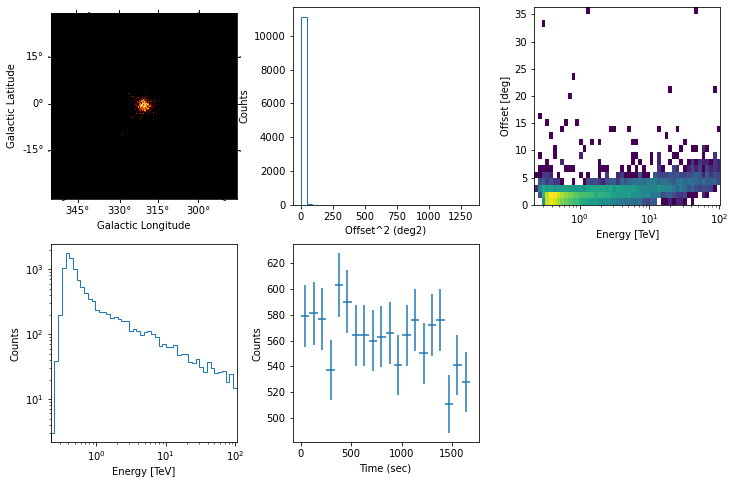

In [25]:
obs.events.peek()

## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis, We choose a WCS based geometry with a binsize of 0.02 deg and also define an energy axis: 

In [26]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

geom = WcsGeom.create(
    skydir=(pos.ra.value, pos.dec.value),
    binsz=0.02,
    width=(4, 4),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", name="energy_true"
)

Now we can define the target dataset with this geometry.

In [27]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="msh-stacked"
)

## Data reduction

### Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.

In [28]:
offset_max = 2.3 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=offset_max
)

In [29]:
circle = CircleSkyRegion(
    center=SkyCoord(pos.ra, pos.dec), radius=0.4 * u.deg
)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

In [30]:
exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

The `FoVBackgroundMaker` performs the background normalisation outside the exclusion region

### Perform the data reduction loop

In [31]:
%%time

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 20136: 0.94
Background norm obs 20137: 0.96
Background norm obs 20151: 0.90
Background norm obs 20282: 0.88
Background norm obs 20283: 0.64
Background norm obs 20301: 0.93
Background norm obs 20302: 0.94
Background norm obs 20303: 0.93
Background norm obs 20322: 1.00
Background norm obs 20323: 0.97
Background norm obs 20324: 0.97
Background norm obs 20325: 0.94
Background norm obs 20343: 0.90
Background norm obs 20344: 0.98
Background norm obs 20345: 0.93
Background norm obs 20346: 0.98
Background norm obs 20365: 0.96
Background norm obs 20366: 0.90
Background norm obs 20367: 0.91
Background norm obs 20368: 0.83
CPU times: user 22.5 s, sys: 484 ms, total: 23 s
Wall time: 23.1 s


In [32]:
print(stacked)

MapDataset
----------

  Name                            : msh-stacked 

  Total counts                    : 55762 
  Total background counts         : 54873.78
  Total excess counts             : 888.22

  Predicted counts                : 54873.78
  Predicted background counts     : 54873.78
  Predicted excess counts         : nan

  Exposure min                    : 5.69e-03 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 509782 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Inspect the reduced dataset

In [33]:
stacked.counts.smooth(0.04 * u.deg).plot_interactive(
    stretch="sqrt", add_cbar=True
);

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

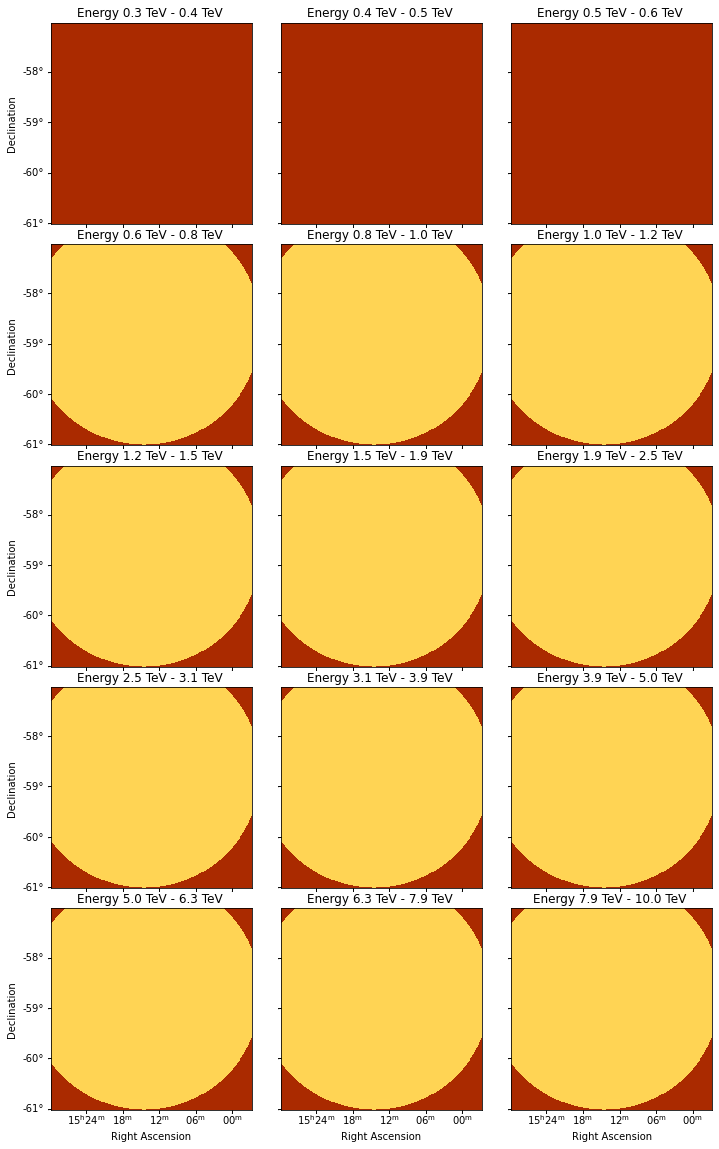

In [34]:
dataset.mask_safe.plot_grid(vmin=-1, vmax=2);

Save the dataset to disc using `~gammapy.datasets.MapDataset.write()` method:

In [35]:
filename = "msh-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

In [36]:
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (228.32083333, -59.08166667)>

(<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

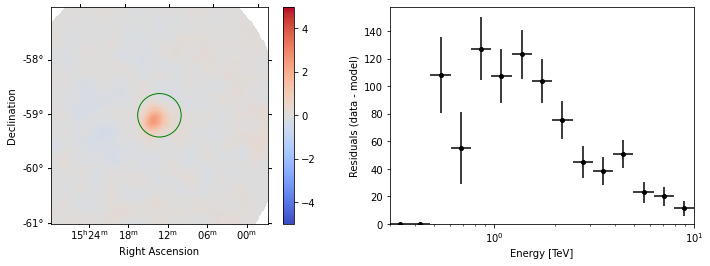

In [37]:
region = CircleSkyRegion(
    center=SkyCoord(228.32083333, -59.08166667, unit="deg"), radius=0.4 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region})

In [38]:
stacked.exposure

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (200, 200, 20)
	ndim  : 3
	unit  : m2 s
	dtype : float32

At this stage, we have created a DL4 dataset.
Now, we perform a fit on it 

## Compute an excess and a significance map

In [138]:
from gammapy.estimators import ExcessMapEstimator

In [139]:
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked)

In [140]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

<WCSAxesSubplot:title={'center':'Excess map'}, xlabel='Right Ascension', ylabel='Declination'>

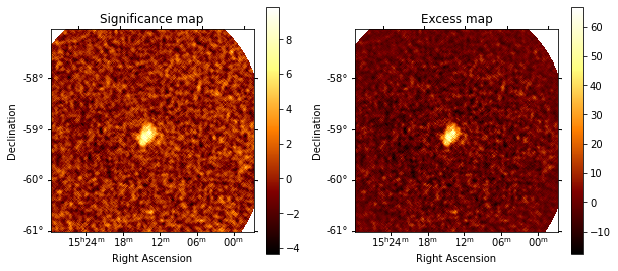

In [141]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

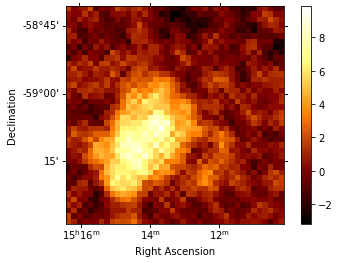

In [144]:
## You can zoom into your region
significance_map.cutout(position=pos, width=0.8*u.deg).plot(add_cbar=True)

## Define the model
We first define the model, a `SkyModel`, as the combination of a point source `SpatialModel` with a powerlaw `SpectralModel`:

In [145]:

spatial_model = GaussianSpatialModel(
    lon_0=pos.ra, lat_0=pos.dec, sigma=0.3*u.deg, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="msh"
)

bkg_model = FoVBackgroundModel(dataset_name="msh-stacked")

Now we assign this model to our reduced dataset:

In [146]:
stacked.models = Models([sky_model, bkg_model])

In [147]:
print(stacked)

MapDataset
----------

  Name                            : msh-stacked 

  Total counts                    : 55762 
  Total background counts         : 54873.78
  Total excess counts             : 888.22

  Predicted counts                : 61261.45
  Predicted background counts     : 54873.78
  Predicted excess counts         : 6387.67

  Exposure min                    : 5.69e-03 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 509782 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 309752.71

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : msh
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
      ind

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its constructor takes a list of dataset as argument.

In [148]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.49645898, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.49645898, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (201.14520768, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (201.14520768, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (228.32083333, -56.2826393)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (228.32083333, -56.2826393)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (228.32083333, -61.78368305)> is outside valid IRF map range, using nearest IRF defined within
P

CPU times: user 12 s, sys: 106 ms, total: 12.1 s
Wall time: 12.1 s


The `FitResult` contains information about the optimization and parameter error calculation.

In [149]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 329
	total stat : 307163.18

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



The fitted parameters are visible from the `~astropy.modeling.models.Models` object.

In [150]:
stacked.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,str1
msh,spectral,index,2.1675e+00,,6.478e-02,nan,nan,False,
msh,spectral,amplitude,6.7415e-12,cm-2 s-1 TeV-1,4.041e-13,nan,nan,False,
msh,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
msh,spatial,lon_0,2.2853e+02,deg,1.358e-02,nan,nan,False,
msh,spatial,lat_0,-5.9175e+01,deg,7.172e-03,-9.000e+01,9.000e+01,False,
msh,spatial,sigma,9.3111e-02,deg,5.527e-03,0.000e+00,nan,False,
msh,spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,
msh,spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,
msh-stacked-bkg,spectral,norm,9.9807e-01,,4.342e-03,nan,nan,False,


### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few options on the dataset object to handle this. First we can use `.plot_residuals_spatial()` to plot a residual image, summed over all energies:

(<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

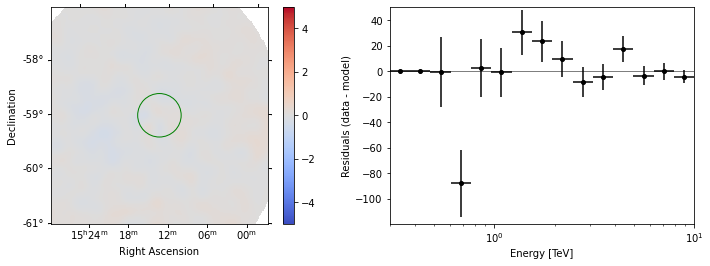

In [151]:
region = CircleSkyRegion(
    center=SkyCoord(228.32083333, -59.08166667, unit="deg"), radius=0.4 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region})

## Plot the fitted spectrum

### Making a butterfly plot 

The `SpectralModel` component can be used to produce a, so-called, butterfly plot showing the envelope of the model taking into account parameter uncertainties:

In [152]:
spec = sky_model.spectral_model

Now we can actually do the plot using the `plot_error` method:

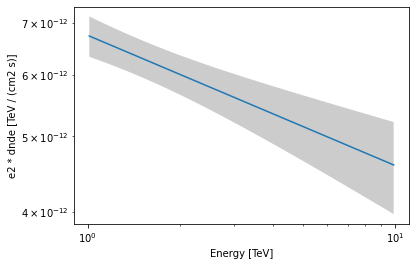

In [153]:
energy_bounds = [1, 10] * u.TeV
spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)

### Computing flux points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [154]:
energy_edges = [0.5, 1, 2, 4, 10] * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="msh")

In [155]:
%%time
flux_points = fpe.run(datasets=[stacked])

CPU times: user 2.56 s, sys: 46 ms, total: 2.61 s
Wall time: 2.61 s


<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde (TeV / (cm2 s))'>

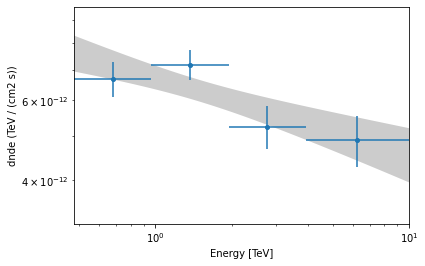

In [156]:
ax = spec.plot_error(energy_bounds=[0.3, 20] * u.TeV, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)